In [3]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn

In [4]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np

In [5]:
from tqdm import tqdm

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
np.random.seed = 42

NUM_QUBITS = 3
NUM_SHOTS = 5000
SHIFT = np.pi/4
LEARNING_RATE = 0.01
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [8]:
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['000', '001', '010', '011', '100', '101', '110', '111']


In [9]:
class QiskitCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas ={k : Parameter('Theta'+str(k))for k in range(self.n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)
        

        self.circuit.measure_all()
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
        
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) /shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        backend = Aer.get_backend('qasm_simulator')
    
        bound_circuit = self.circuit.bind_parameters({self.thetas[k] : params[k].item() for k in range(NUM_QUBITS)}) 
        job_sim = execute(bound_circuit, self.backend, shots=self.shots)
        
        result_sim = job_sim.result()
        counts = result_sim.get_counts()
        return self.N_qubit_expectation_Z(counts,self.shots,NUM_QUBITS)

Expected value for rotation [pi/4]: [0.0038 0.0188 0.0192 0.1134 0.0198 0.1036 0.1042 0.6172]


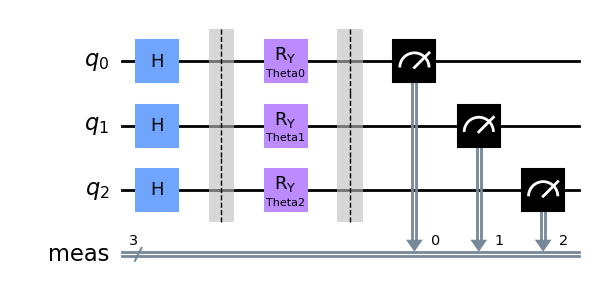

In [11]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*NUM_QUBITS))))
circuit.circuit.draw(output='mpl')

In [12]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
            
        exp_value = ctx.QiskitCirc.run(i)
        
        result = torch.tensor([exp_value])
        
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        
        forward_tensor, i = ctx.saved_tensors
        input_numbers = i
        gradients = torch.Tensor()
        
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
            
            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)

        return (result.float() * grad_output.float()).T

In [13]:
x = torch.tensor([np.pi/4]*NUM_QUBITS, requires_grad=True)

qc = TorchCircuit.apply
y1 = qc(x)
print('y1 after quantum layer: {}'.format(y1))
y1 = nn.Linear(2**NUM_QUBITS,1)(y1.float())
y1.backward()
print('x.grad = {}'.format(x.grad))

/tmp/ipykernel_16310/1768170039.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/torch/csrc/utils/tensor_new.cpp:245.)
  result = torch.tensor([exp_value])


y1 after quantum layer: tensor([[0.0024, 0.0198, 0.0192, 0.1090, 0.0196, 0.0996, 0.1110, 0.6194]],
       dtype=torch.float64, grad_fn=<TorchCircuitBackward>)
x.grad = tensor([-0.1918, -0.1454, -0.0571])


### FashionMNIST in pytorch

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [75]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

n_samples = 150

X_train = datasets.FashionMNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 3)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 4)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 5)[0][:n_samples])


X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

**Testing Data**

In [76]:
n_samples = 150

X_test = datasets.FashionMNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 3)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 4)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 5)[0][:n_samples])


X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [86]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_QUBITS)
        self.qc = TorchCircuit.apply
        self.qcsim = nn.Linear(NUM_QUBITS, 1)
        self.fc3 = nn.Linear(1, 3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = np.pi*torch.tanh(x)
        

        MODE = 'QC'
    
        if MODE == 'QC': 
            x = qc(x[0]) # QUANTUM LAYER
        
        else:
            x = self.qcsim(x)

        x = torch.sigmoid(x)
        x = torch.cat((x, 1-x), -1)
        return x
    
    
    def predict(self, x):
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)
    
network = Net()
optimizer = optim.Adam(network.parameters(), lr=0.001)

In [88]:
total_params = sum(p.numel() for p in network.parameters() if p.requires_grad)
print("Number of trainable parameters:", total_params)

Number of trainable parameters: 21493


In [89]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=6):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(384 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 384 * 7 * 7)
        x = self.classifier(x)
        return x


In [90]:
teacher_model = AlexNet(num_classes=6)
teacher_model.load_state_dict(torch.load("alexnet fashionmnist 0-5.pth"))
teacher_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=18816, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=4096, out_features=6, bias=True)
  )
)

In [91]:
def distillation_loss(y, teacher_scores, T=3.0, alpha=0.9):
    # Get the soft targets from the teacher model
    teacher_probs = F.softmax(teacher_scores / T, dim=1)
    # Calculate KL divergence
    kd_loss = nn.KLDivLoss()(F.log_softmax(y/T, dim=1), teacher_probs) * (T * T * 6 * alpha)
    return kd_loss


In [92]:
epochs = 10
loss_list = []
val_loss_list = []
loss_func = nn.CrossEntropyLoss()
best = 0

for epoch in range(epochs):
    network.train()
    
    total_loss = []
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
#         print(batch_idx)
        optimizer.zero_grad()        
        # Forward pass
        output = network(data)
        
        # Forward pass in teacher
        with torch.no_grad():
            output_teacher = teacher_model(data)
            
        # Calculating loss
        loss = loss_func(output, target)
        
        # Calculate the distillation loss using only first 6 outputs of student
        kd_loss = distillation_loss(output[:, :6], output_teacher)
        
        loss = loss + kd_loss
        
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))
    
    network.eval()
    
    accuracy = 0
    number = 0
    
    with torch.no_grad():
        total_val_loss = []
        for batch_idx, (data, target) in enumerate(test_loader):
            number +=1
            output = network(data)
            
            # Calculating loss
            loss = loss_func(output, target)
            
            output = network.predict(data).item()
            
            total_val_loss.append(loss.item())
        
            accuracy += (output == target[0].item())*1
            
        accuracy = 100*accuracy/number
        
        if accuracy > best:
            best = accuracy
            torch.save(network.state_dict(), 'distil t=alex s=0-5 fashion 3qubits.pth')
            
        val_loss_list.append(sum(total_val_loss)/len(total_val_loss))
        print("Val loss: {} and accuracy = {}%".format(val_loss_list[-1],accuracy))

100%|█████████████████████████████████████████| 900/900 [01:41<00:00,  8.86it/s]


Training [10%]	Loss: 13.9951
Val loss: 2.746296235107987 and accuracy = 16.444444444444443%


100%|█████████████████████████████████████████| 900/900 [01:41<00:00,  8.89it/s]


Training [20%]	Loss: 13.8720
Val loss: 2.648700421128383 and accuracy = 62.333333333333336%


100%|█████████████████████████████████████████| 900/900 [01:39<00:00,  9.05it/s]


Training [30%]	Loss: 13.7538
Val loss: 2.629573878702963 and accuracy = 70.66666666666667%


100%|█████████████████████████████████████████| 900/900 [01:38<00:00,  9.13it/s]


Training [40%]	Loss: 13.7125
Val loss: 2.619258808568202 and accuracy = 74.33333333333333%


100%|█████████████████████████████████████████| 900/900 [01:41<00:00,  8.91it/s]


Training [50%]	Loss: 13.6794
Val loss: 2.6091184672914127 and accuracy = 80.0%


100%|█████████████████████████████████████████| 900/900 [01:41<00:00,  8.86it/s]


Training [60%]	Loss: 13.6652
Val loss: 2.614241134414652 and accuracy = 79.88888888888889%


100%|█████████████████████████████████████████| 900/900 [01:40<00:00,  8.98it/s]


Training [70%]	Loss: 13.6459
Val loss: 2.6135589277516824 and accuracy = 78.66666666666667%


100%|█████████████████████████████████████████| 900/900 [01:39<00:00,  9.09it/s]


Training [80%]	Loss: 13.6313
Val loss: 2.6014141197469876 and accuracy = 82.44444444444444%


100%|█████████████████████████████████████████| 900/900 [01:38<00:00,  9.12it/s]


Training [90%]	Loss: 13.6187
Val loss: 2.599539110359346 and accuracy = 82.44444444444444%


100%|█████████████████████████████████████████| 900/900 [01:40<00:00,  8.95it/s]


Training [100%]	Loss: 13.6277
Val loss: 2.597595598262035 and accuracy = 83.44444444444444%


In [93]:
print('Best accuracy = {}'.format(best))

Best accuracy = 83.44444444444444
